In [57]:
# 1-a Load Data
import numpy as np
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

data, label = [], []
for line in open("./data/amazon_cells_labelled.txt"):
    l = line.strip().split("\t")
    data.append(l[0])
    label.append(l[1])
for line in open("./data/imdb_labelled.txt"):
    l = line.strip().split("\t")
    data.append(l[0])
    label.append(l[1])
for line in open("./data/yelp_labelled.txt"):
    l = line.strip().split("\t")
    data.append(l[0])
    label.append(l[1])
data = np.array(data)
label = np.array(label)

In [58]:
# 1-b Preprocess
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
# Lowercase all of the words
data = np.char.lower(data)

# Stripping Punctuation
for i in range(len(data)):
    data[i] = re.sub('[^\w\s]',' ', data[i])

# Lemmatizing & Remove Stop Words
stemmer = PorterStemmer()
for i in range(len(data)):
    s = []
    for word in data[i].split():
        try:
            if word not in stopwords.words("english"):
                s.append(stemmer.stem(word))
        except:
            pass
    data[i] = " ".join(s)

In [59]:
# 1-c Split Training and Testing Set
train_data, train_label = [], []
test_data, test_label = [], []
for f in range(0, 3):
    start = f*1000
    one = 0
    zero = 0
    for i in range(start, start+1000):
        if label[i] == 1:
            one += 1
            if one <= 400:
                train_data.append(data[i])
                train_label.append(1)
            else:
                test_data.append(data[i])
                test_label.append(1)
        else:
            zero += 1
            if zero <= 400:
                train_data.append(data[i])
                train_label.append(0)
            else:
                test_data.append(data[i])
                test_label.append(0)

train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [60]:
# 1-d Bag of Words Model.
# Get dictionary from training data
word_dict = dict()
index = 0
for s in train_data:
    for w in s.split():
        if w not in word_dict:
            word_dict[w] = index
            index += 1

# Get training and test features
train_feat, test_feat = [], []
word_count = len(word_dict)
for s in train_data:
    cur = [0] * word_count
    for w in s.split():
        cur[word_dict[w]] += 1
    train_feat.append(cur)
train_feat = np.array(train_feat, dtype=float)
for s in test_data:
    cur = [0] * word_count
    for w in s.split():
        if w in word_dict:
            cur[word_dict[w]] += 1
    test_feat.append(cur)
test_feat = np.array(test_feat, dtype=float)

In [61]:
# 1-e Postprocessing Strategy  
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
train_post = transformer.fit_transform(train_feat).toarray()
test_post = transformer.fit_transform(test_feat).toarray()

//anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:993: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [97]:
# 1-f Training Set Clustering
from sklearn.metrics.pairwise import cosine_similarity

def k_means(k, features):
    random_indices = np.random.choice(range(len(features)), k, replace=False)
    initials_centroids = get_feat(random_indices, features)
    return helper(k, features, initials_centroids, None)

def get_feat(indices, features):
    feats = []
    for i in indices:
        feats.append(features[i])
    return np.array(feats)

def helper(k, features, centroids, prev):
    clusters = {}
    
    # Assign to Centroids
    for i in range(len(features)):
        dists = []
        f = features[i]
        for c in centroids:
            nf = np.linalg.norm(f)
            nc = np.linalg.norm(c)
            d = -1 * np.dot(f, c.T) / (nf * nc)
            #dists.append(np.linalg.norm(f - c))
            dists.append(d)
        assignment = np.argmin(dists)
        if assignment in clusters:
            clusters[assignment].append(i)
        else:
            clusters[assignment] = [i]
    if clusters == prev:
        return(clusters, centroids)
    
    # Update Centroids
    new_centroids = []
    for c in clusters.keys():
        cluster = get_feat(clusters[c], features)
        new_centroids.append(np.mean(cluster, axis=0))    
    return helper(k, features, new_centroids, clusters)

def run_km(k, features, labels):
    clusters, centroids = k_means(k, features)
    count0 = len(clusters[0])
    zero0 = 0
    acc = 0
    for i in clusters[0]:
        if 0 == labels[i]:
            zero0 += 1
            acc += 1
    for i in clusters[1]:
        if 1 == labels[i]:
            acc += 1
    print("Cluster0: {}, zero0: {}".format(count0, zero0))
    rate = acc / len(features)
    if rate < 0.5:
        rate = 1 - rate
    print("K Means Accuracy: {}".format(rate))
run_km(2, train_post, train_label)

Cluster0: 1101, zero0: 604
K Means Accuracy: 0.5445833333333333


Logistic Regression Accuracy: 0.8266666666666667
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.22  0.78]]


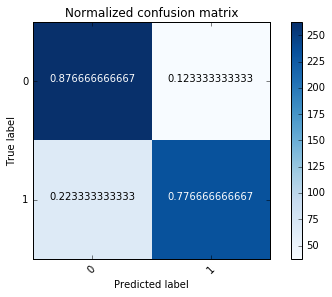

great
love
bad
excel
good
nice
poor
delici
amaz
best


In [63]:
# 1-g Sentiment Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def run_log(train, train_label, test, test_label, dictionary):    
    # Compute Log Regression
    clf_L = LogisticRegression()
    clf_L.fit(train, train_label)
    acc_L = clf_L.score(test, test_label)
    print("Logistic Regression Accuracy: {}".format(acc_L))

    # Confusion Matrix
    y_pred = clf_L.predict(test)
    cm = confusion_matrix(test_label, y_pred)
    np.set_printoptions(precision=2)
    class_names = {"0", "1"}
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    # Show most significant words
    indices = np.argsort(np.absolute(clf_L.coef_))[0]
    significant = [indices[-1], indices[-2], indices[-3], indices[-4], indices[-5],
              indices[-6], indices[-7], indices[-8], indices[-9], indices[-10]]     
    for i in significant:
        for w in dictionary.keys():
            if dictionary[w] == i:
                print(w)
                
run_log(train_post, train_label, test_post, test_label, word_dict)

//anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:993: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


Cluster0: 2399, zero0: 1200
K Means Accuracy: 0.5004166666666666
Logistic Regression Accuracy: 0.645
Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.61  0.39]]


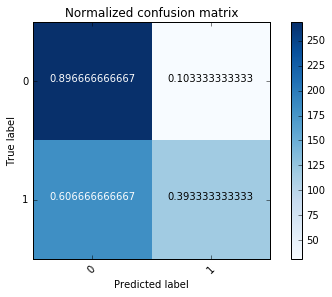

work great
highli recommend
wast time
great phone
disappoint
wast money
one best
great product
10 10
food good


In [98]:
# 1-h N-gram Model
# Bag of N-grams
def get_ngram(sentence, n):
    res = []
    w = sentence.split()
    if len(w) <= n:
        return [sentence]
    for i in range(len(w) - n + 1):
        res.append(" ".join(w[i:i+n]))
    return res

# Get dictionary from training data
def get_dict_ng(n):
    word_dict = dict()
    index = 0
    for s in train_data:
        for ng in get_ngram(s, n):
            if ng not in word_dict:
                word_dict[ng] = index
                index += 1
    return word_dict

# Get training and test features
def get_feat_ng(input_data, ng_dict, n):
    feat_ng = []
    ng_count = len(ng_dict)
    for s in input_data:
        cur = [0] * ng_count
        for ng in get_ngram(s, n):
            if ng in ng_dict:
                cur[ng_dict[ng]] += 1
        feat_ng.append(cur)
    return np.array(feat_ng)

ng_dict = get_dict_ng(2)
train_feat_ng = get_feat_ng(train_data, ng_dict, 2)
test_feat_ng = get_feat_ng(test_data, ng_dict, 2)
train_post_ng = transformer.fit_transform(train_feat_ng).toarray()
test_post_ng = transformer.fit_transform(test_feat_ng).toarray()

# K Means
run_km(2, train_post_ng, train_label)

# Log Regression
run_log(train_post_ng, train_label, test_post_ng, test_label, ng_dict)

PCA 10
Cluster0: 780, zero0: 318
K Means Accuracy: 0.56
Logistic Regression Accuracy: 0.5383333333333333
Normalized confusion matrix
[[ 0.43  0.57]
 [ 0.36  0.64]]


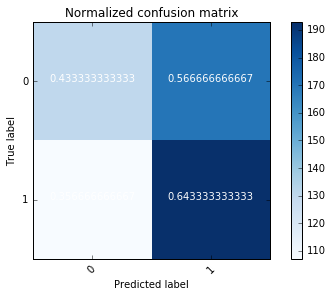

PCA 50
Cluster0: 765, zero0: 321
K Means Accuracy: 0.55125
Logistic Regression Accuracy: 0.57
Normalized confusion matrix
[[ 0.45  0.55]
 [ 0.31  0.69]]


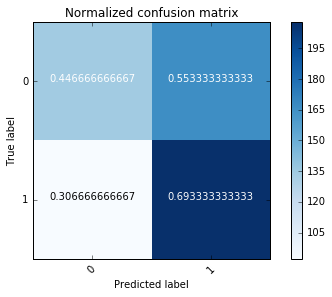

PCA 100
Cluster0: 239, zero0: 116
K Means Accuracy: 0.5083333333333333
Logistic Regression Accuracy: 0.5566666666666666
Normalized confusion matrix
[[ 0.48  0.52]
 [ 0.37  0.63]]


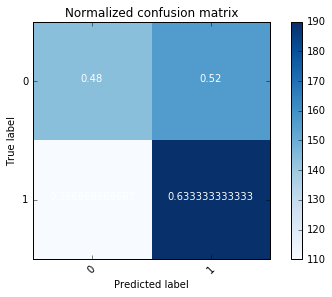

In [99]:
def pca(features, n):
    features -= features.mean(axis=0)
    R = np.cov(features, rowvar=False)
    evals, evecs = np.linalg.eigh(R)
    idx = np.argsort(evals)[::-1]
    evecs, evals = evecs[:, idx], evals[idx]
    evecs, evals = evecs[:, :n], evals[:n]
    return np.dot(evecs.T, features.T).T
    
train_pca10 = pca(train_post, 10)
test_pca10 = pca(test_post, 10)
train_pca50 = pca(train_post, 50)
test_pca50 = pca(test_post, 50)
train_pca100 = pca(train_post, 100)
test_pca100 = pca(test_post, 100)
print("PCA 10")
run_km(2, train_pca10, train_label)
run_log(train_pca10, train_label, test_pca10, test_label, {})
print("PCA 50")
run_km(2, train_pca50, train_label)
run_log(train_pca50, train_label, test_pca50, test_label, {})
print("PCA 100")
run_km(2, test_pca50, train_label)
run_log(train_pca100, train_label, test_pca100, test_label, {})